## Evaluation.ipynb

---

Evaluates the performances of the trained model:<br>
First extracts the validation and prediction polygons.<br>
Then, builds the precision-recall curve and retrives the best performance.

Our fine-tuned model detects irrigation ponds greater than 230 m² of size <br>
with a F1 score of 0.91 (Recall=0.90, Precision=0.92) <br>

Metrics used:

    * Dice score
    * Precision
    * Recall
    * F1 Score

    **** This code takes to much time. Improves are welcome


Required Third-party libraries:
    
    * geopandas
    * numpy
    * pandas

Requiered custom modules:
    
    * ./functions/utils
    * ./functions/load_data
    * ./functions/georeferencing_polygons
    * ./functions/evaluate_functions


In [1]:
%matplotlib inline

# //-------------------------------------------------------------\\

# Imports
import os
import re
import sys
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import multiprocessing as mp
from IPython.display import display

# Custom modules
sys.path.append('../functions')
import evaluate_functions as evf
import georeferencing_polygons as rp
from load_data import DataGenerator
from utils import files_paths
from utils import save_pickle
from utils import load_pickle

Using TensorFlow backend.


In [2]:
# Load images and predictions

# //-------------------------------------------------------------\\

# Input parameters

# Path where validation imagesare stored
validation_images_path = '../Data/Images/Validation_Images'
data_suffix = '_data.png'
labels_suffix = '_labels.png'

# Model date creation
weights_id = '2018-11-23_20_28_57'
prediction_suffix = '_prediction.png'

predictions_path = '../Outputs/Validation_Images/predictions/'
predictions_path = os.path.join(predictions_path, weights_id)

# //-------------------------------------------------------------\\

# Validation labels
validation_labels_paths = files_paths(validation_images_path, 
                                      nested_carpets=True, exts=labels_suffix)

# Prediction probability masks
predictions_paths = [i.replace(validation_images_path, 
                               predictions_path) for i in validation_labels_paths]
predictions_paths = [i.replace(labels_suffix, 
                               prediction_suffix) for i in predictions_paths]

# //-------------------------------------------------------------\\

In [3]:
# Fit the generator objects

# //-------------------------------------------------------------\\

# Input user parameters

batch_size = 1

# Image pre-processing
val_prep_funcs = ['crop', 'zero padding', 'pick channels']
val_prep_params = {'crop_size':20, 'pad_size': 20, 'idxs_channel': 0}

pred_prep_funcs = ['zero padding', 'pick channels']
pred_prep_params = {'pad_size': 20, 'idxs_channel': 0}

# //-------------------------------------------------------------\\

input_parameters = {'ims_paths' : validation_labels_paths,
                    'batch_size' : batch_size,
                    'im_prep_funcs' : val_prep_funcs,
                    'im_prep_params' : val_prep_params}
validation_images = DataGenerator(**input_parameters)


input_parameters = {'ims_paths' : predictions_paths,
                    'batch_size' : batch_size,
                    'im_prep_funcs' : pred_prep_funcs,
                    'im_prep_params' : pred_prep_params,}
prediction_images = DataGenerator(**input_parameters)

print('\nEvaluating on:')
print(validation_images)



Evaluating on:

DataGenerator object 

Information:

      Number of samples : 1600
      Image height : 552
      Image width : 552
      Number of channels : 1
      Number of classes : None



In [4]:
# Load the csv file with the referece coordinates for each image

# //-------------------------------------------------------------\\

# Input parameters

# CSV file where reference coordinates are saved for each image
validation_images_info = '../Data/Images/Validation_Images/validation_images_info.csv'

# Columns names
center_lat = 'center_lat'
center_long = 'center_long'
image_filename = 'filename'

# //-------------------------------------------------------------\\

validation_images_info = pd.read_csv(validation_images_info)
validation_images_info.head()

# //-------------------------------------------------------------\\

,center_long,center_lat,filename
0,-101.940320,19.376468,Image_2018-9-6_13_50_0_917097
1,-101.971228,19.375966,Image_2018-9-6_13_50_0_916923
2,-101.937942,19.376506,Image_2018-9-6_13_50_2_549084
3,-101.968850,19.376004,Image_2018-9-6_13_50_2_550574
4,-101.966473,19.376043,Image_2018-9-6_13_50_3_684410


In [5]:
# //---------------------- Local Functions ----------------------\\
# //-------------------------------------------------------------\\

def get_reference_coordinate(im_path):
    '''Helper function to retrieve the image center from csvfile'''
    image_name = os.path.split(im_path)[1]
    if not re.findall(data_suffix, image_name):
        image_name = image_name.replace(labels_suffix, data_suffix)
        image_name = image_name.replace(prediction_suffix, data_suffix)

    mask = validation_images_info.filename.apply(lambda x: re.findall(image_name, x))
    mask = mask.apply(lambda x: len(x) > 0)
    center = validation_images_info[[center_long,center_lat]][mask].values[0]
    return center

# //-----------------------------------------------------------------------------------\\

def extract_polygons(idx, flag='validation', thr_decision=0.9):
    '''Pipeline for extract the polygons in one image'''
    # Get the image
    if flag == 'validation':
        im = validation_images[idx][0]
        im_path = validation_images.batch_ims_paths[0]

    elif flag == 'prediction':
        im = prediction_images[idx][0]
        im_path = prediction_images.batch_ims_paths[0]

    # Get the reference center
    center = get_reference_coordinate(im_path)

    # Fit the polygon extractor
    input_parameters = {'im' : im,
                        'center' : center,
                        'crs_rep' : crs_rep,
                        'zoom' : zoom,
                        'thr_decision' : thr_decision}

    p = rp.PolygonsExtractor(**input_parameters)
    if idx == 0 and flag=='validation':
        print('\nGeographic reference information:')
        print(f'Pixel resolution X : {p.resolution_x:.6f}')
        print(f'Pixel resolution Y : {p.resolution_y:.6f}')
        print(f'Zoom image : {p.zoom}')
        print(f'CRS : {p.crs}')
        print(f'Threshold decision : {p.thr_decision}\n')

    # Get the polygons
    polygons = list(p.get_polygons().values())
    return polygons

# //-----------------------------------------------------------------------------------\\

def metrics_by_thr(thr_decision=0.9):
    global val_polygons
    '''Computes metrics by threshold decision'''
    
    print(f'Current threshold decision: {thr_decision:.2f}')

    # Return the predicted polygons by given threshold
    pred_polygons = [extract_polygons(idx, 'prediction', thr_decision=thr_decision)
                        for idx in range(len(prediction_images))]
    pred_polygons = np.concatenate(pred_polygons)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        pred_polygons = rp.dissolve_polygons(pred_polygons)
        pred_polygons = pred_polygons.to_crs(crs_rep)


    # Get metrics
    _, _, tp, fp, fn, d, displacement = evf.prediction_metrics(val_polygons, 
                                                               pred_polygons)
    
    tp_areas = pred_polygons.iloc[tp].area.values
    fp_areas = pred_polygons.iloc[fp].area.values
    fn_areas = val_polygons.iloc[fn].area.values

    # Return metrics
    metrics = {'tp_areas': tp_areas,
               'fp_areas': fp_areas,
               'fn_areas': fn_areas,
               'dice_coeff': d, 
               'displacement': displacement}

    return metrics

# //-----------------------------------------------------------------------------------\\

def precision_recall_by_thr(metrics):
    '''Retrives precision and recall for all trhresholds'''

    stats = [evf.get_stats(i) for i in metrics]
    
    tps = np.concatenate([i[0].Total.values for i in stats])
    fps = np.concatenate([i[1].Total.values for i in stats])
    fns = np.concatenate([i[2].Total.values for i in stats])
    
    recall = evf.recall(tps, fns)
    precision = evf.precision(tps, fps)
    
    return precision, recall

# //-----------------------------------------------------------------------------------\\

In [9]:
# Extracting polygons from validation and predictions sets
# Then get metrics for all the thresholds

# //-------------------------------------------------------------\\

# Input parameters

# The PolygonExtractor class needs the referece image center in (long, lat) decimal format. 
# But it also needs a metric coordinate referece system to reproject the reference center. 
# See geopandas documentation:
# http://geopandas.org/
crs_rep = 'epsg:6372'

# Zoom image; see google maps documentation:
# https://developers.google.com/maps/documentation/maps-static/intro
zoom = 18

# Thresholds decision to construct the
# Precision-Recall curve
thresholds = np.linspace(0.01, .99, 50)

# Cores to use in parallel process
n_cores = 4

# //-----------------------------------------------------------------------------------\\

# Outputs

# Creating an output directory with
# to store the validation polygons
output_path = '../Outputs/Validation_Images/validation_polygons'
if not os.path.exists(output_path):
    os.mkdir(output_path)
val_polygons_path = os.path.join(output_path,'polygons.shp')

# Set to True to overwrite the above file
replace_val_polygons = False

# Set to True to restore previous results.
load_pr_curve = True

# Else:
# Creating an output directory with the model ID
# to store the precision-recall curve
output_path = '../Outputs/Validation_Images/precision_recall_curve'
if not os.path.exists(output_path):
    os.mkdir(output_path)
output_path = os.path.join(output_path, weights_id)
if not os.path.exists(output_path):
    os.mkdir(output_path)
precision_recall_curve_path = os.path.join(output_path,'precision_recall_curve.pkl')

# //-------------------------------------------------------------\\

# //-------------------------------------------------------------------------------\\

# Extracting polygons in validation set
if not os.path.exists(val_polygons_path) or replace_val_polygons:

    print('\nExtracting validation polygons')
    # Parallel processing
    pool = mp.Pool(processes=n_cores)
    val_polygons = pool.map(extract_polygons, range(len(validation_images)))
    pool.close()
    
    # Dissolve
    val_polygons = np.concatenate(val_polygons)
    val_polygons = rp.dissolve_polygons(val_polygons)
    val_polygons = val_polygons.to_crs(crs_rep)
    val_polygons.to_file(driver='ESRI Shapefile', filename=val_polygons_path)
    print(f'\nSaving validation polygons at: {val_polygons_path}')
else:
    print(f'Loading validation polygons from: {val_polygons_path}')
    val_polygons = gpd.read_file(val_polygons_path)
    val_polygons = val_polygons.to_crs(crs_rep)

# //-------------------------------------------------------------------------------\\

# Extracting polygons in predictions

# Process in parallel for each threshold decision
if not load_pr_curve:
    print('\nExtracting predicted polygons')
    pool = mp.Pool(processes=n_cores)
    metrics = pool.map(metrics_by_thr, thresholds)
    pool.close()
    save_pickle(metrics, precision_recall_curve_path)
    print(f'\nSaving metrics at {precision_recall_curve_path}')
else:
    print(f'Loading metrics from: {precision_recall_curve_path}')
    metrics = load_pickle(precision_recall_curve_path)

# //-------------------------------------------------------------------------------\\

Loading validation polygons from: ../Outputs/Validation_Images/validation_polygons/polygons.shp


/home/mefistofeles/anaconda3/envs/py37/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


Loading metrics from: ../Outputs/Validation_Images/precision_recall_curve/2018-11-23_20_28_57/precision_recall_curve.pkl




//--------------------------------------------------------\

Best metrics:

Threshold decision : 0.99
Dice coefficient: 0.5823
Recall: 0.7644
Precision: 0.6059
F1 score: 0.6760


,Total,Percentage,DC,DC std,displacement,displacement std,area,area_std
True Positives,266.0,0.764368,0.58225,0.247504,2.221582,3.931303,344.867632,691.566389


,Total,Percentage,area,area_std
False Positives,173.0,0.650376,37.154893,96.774069


,Total,Percentage,area,area_std
False Negatives,82.0,0.235632,316.924436,1440.413969


//--------------------------------------------------------\




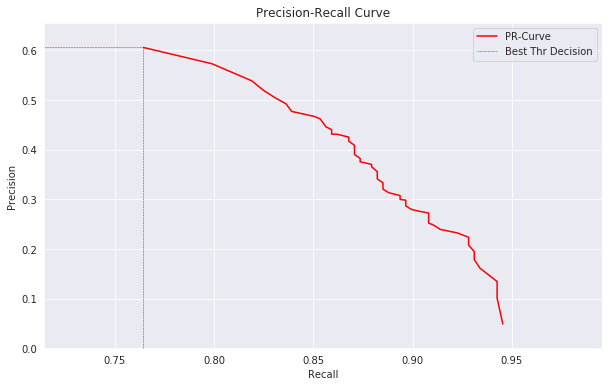

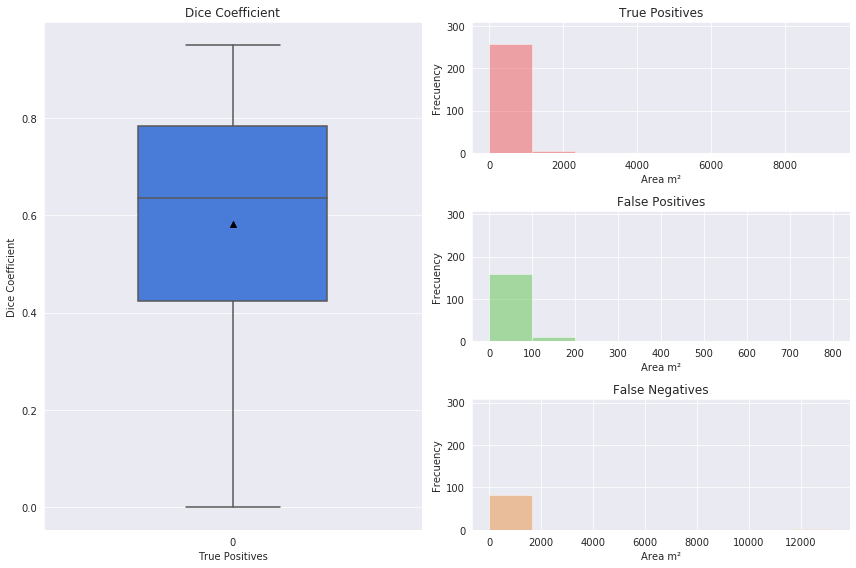

In [10]:
# //-------------------------------------------------------------\\

# Get best scores
precision, recall = precision_recall_by_thr(metrics)
opt_thr = evf.find_best_thr_decision(recall, precision)
m = metrics[opt_thr]
tp_stats, fp_stats, fn_stats = evf.get_stats(m)
f1_score = evf.f1_score(recall[opt_thr], precision[opt_thr])

print('\n')
print('//--------------------------------------------------------\\')
print('\nBest metrics:\n')
print(f'Threshold decision : {thresholds[opt_thr]:.2f}')
print(f'Dice coefficient: {tp_stats["DC"].values[0]:.4f}')
print(f'Recall: {recall[opt_thr]:.4f}')
print(f'Precision: {precision[opt_thr]:.4f}')
print(f'F1 score: {f1_score:.4f}')
display(tp_stats)
display(fp_stats)
display(fn_stats)
print('//--------------------------------------------------------\\')
print('\n')
    
evf.plot_precision_recall_curve(precision, recall, multiline=False, labels=None)
evf.plot_dc_tp_fp_fn(m)


# //-------------------------------------------------------------\\



//--------------------------------------------------------\

Best metrics:

Threshold area: 0 m²
Omitted area: 0 %
Threshold decision: 0.99
Dice coefficient: 0.5823
Recall: 0.7644
Precision: 0.6059
F1 score: 0.6760


,Total,Percentage,DC,DC std,displacement,displacement std,area,area_std
True Positives,266.0,0.764368,0.58225,0.247504,2.221582,3.931303,344.867632,691.566389


,Total,Percentage,area,area_std
False Positives,173.0,0.650376,37.154893,96.774069


,Total,Percentage,area,area_std
False Negatives,82.0,0.235632,316.924436,1440.413969


//--------------------------------------------------------\




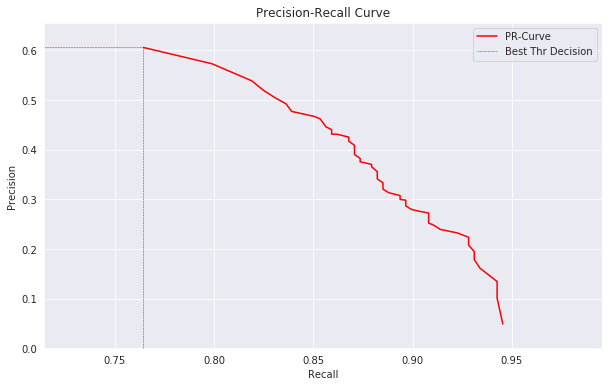

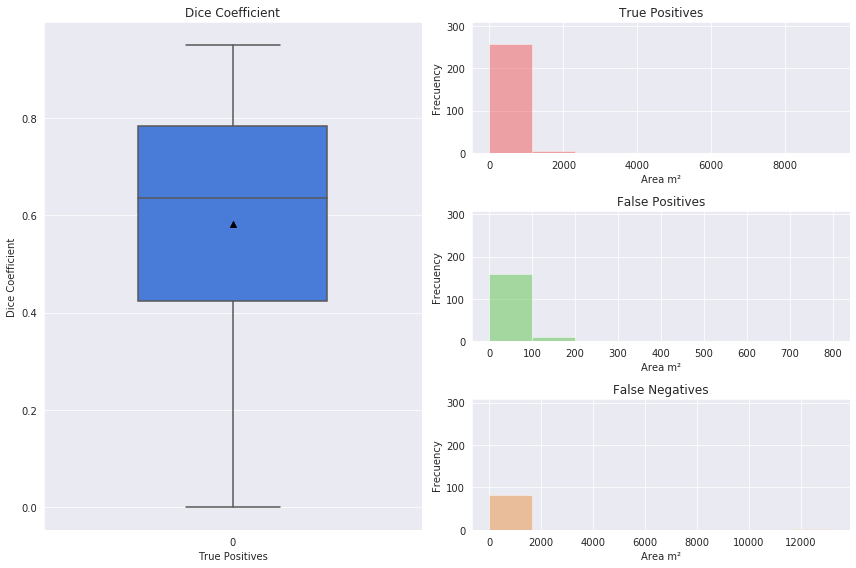



//--------------------------------------------------------\

Best metrics:

Threshold area: 90 m²
Omitted area: 1 %
Threshold decision: 0.95
Dice coefficient: 0.7795
Recall: 0.8346
Precision: 0.8251
F1 score: 0.8298


,Total,Percentage,DC,DC std,displacement,displacement std,area,area_std
True Positives,217.0,0.834615,0.77948,0.12486,1.514871,2.586853,513.703631,844.634192


,Total,Percentage,area,area_std
False Positives,46.0,0.211982,256.387576,229.486375


,Total,Percentage,area,area_std
False Negatives,43.0,0.165385,206.00331,139.208372


//--------------------------------------------------------\




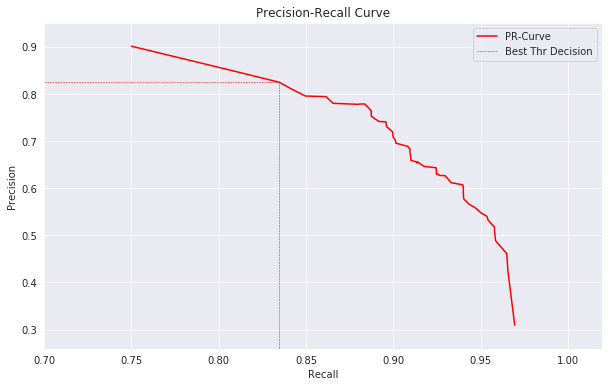

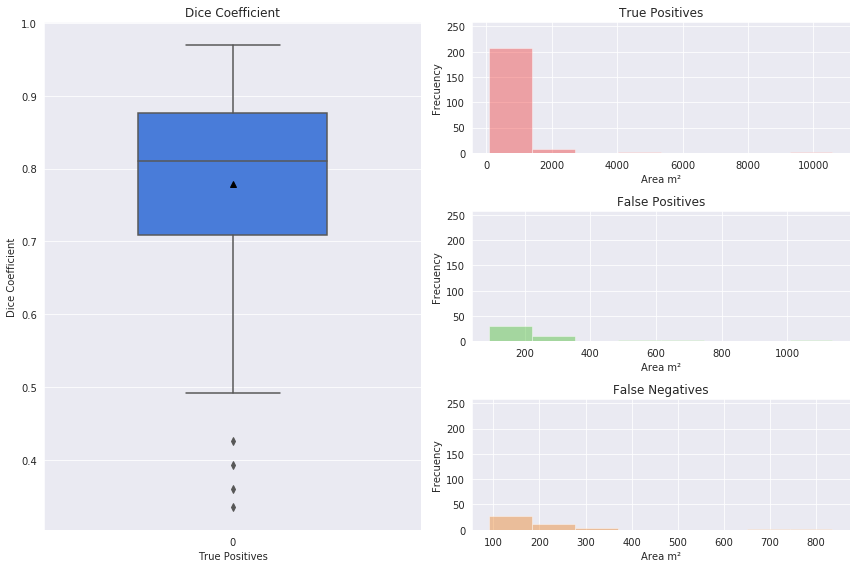



//--------------------------------------------------------\

Best metrics:

Threshold area: 160 m²
Omitted area: 5 %
Threshold decision: 0.99
Dice coefficient: 0.7480
Recall: 0.8263
Precision: 0.9452
F1 score: 0.8818


,Total,Percentage,DC,DC std,displacement,displacement std,area,area_std
True Positives,138.0,0.826347,0.748025,0.130724,1.981312,4.398628,603.795515,883.537336


,Total,Percentage,area,area_std
False Positives,8.0,0.057971,380.188937,241.144173


,Total,Percentage,area,area_std
False Negatives,29.0,0.173653,719.905569,2368.962476


//--------------------------------------------------------\




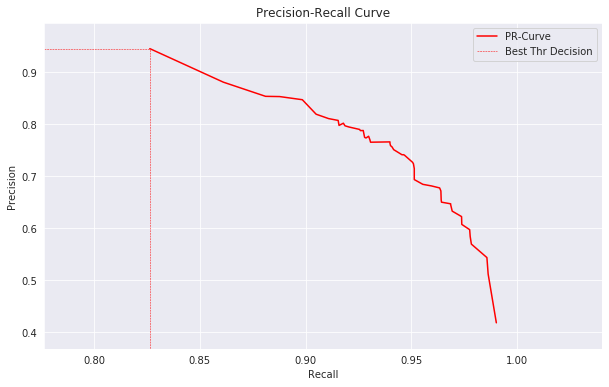

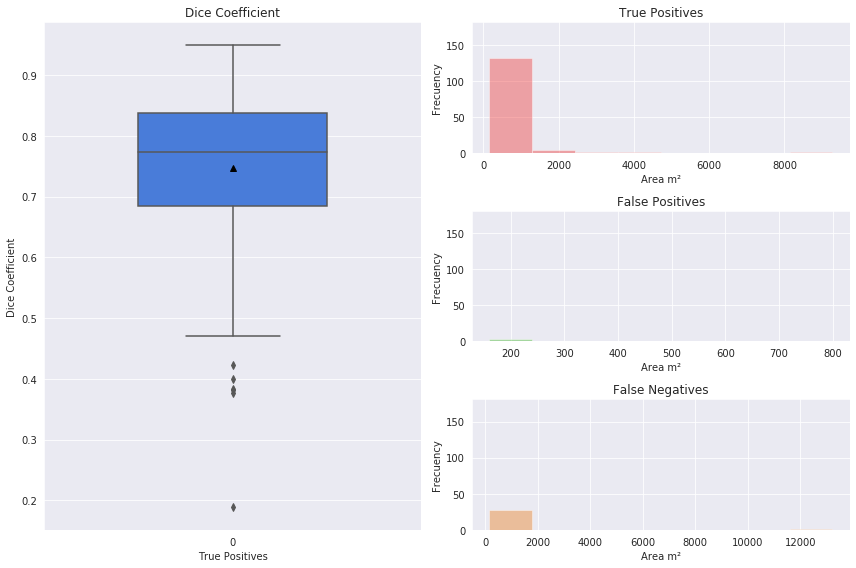



//--------------------------------------------------------\

Best metrics:

Threshold area: 230 m²
Omitted area: 10 %
Threshold decision: 0.97
Dice coefficient: 0.8064
Recall: 0.8980
Precision: 0.9231
F1 score: 0.9103


,Total,Percentage,DC,DC std,displacement,displacement std,area,area_std
True Positives,132.0,0.897959,0.806361,0.112405,1.878276,4.372985,702.473677,972.098405


,Total,Percentage,area,area_std
False Positives,11.0,0.083333,555.0527,286.779865


,Total,Percentage,area,area_std
False Negatives,15.0,0.102041,1202.266121,3219.561354


//--------------------------------------------------------\




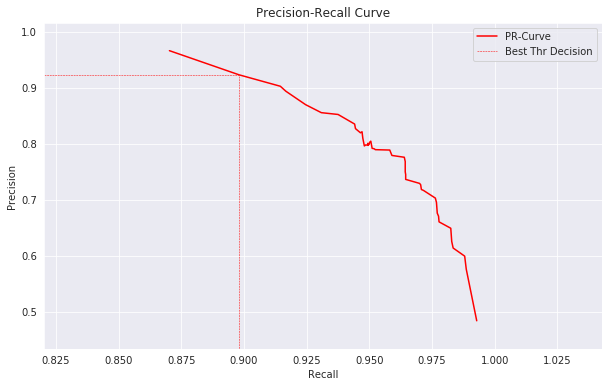

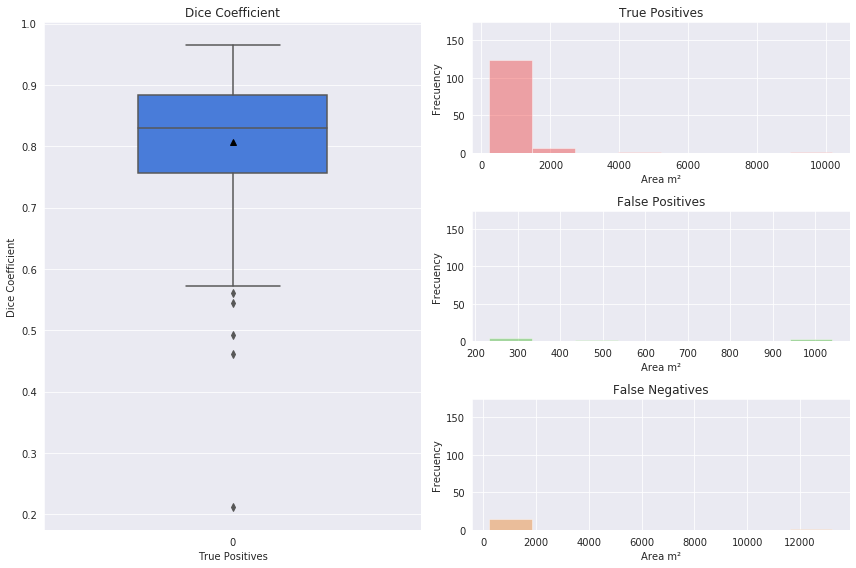

In [11]:
# Thresholding by area to remove the huge amount of false positives

# //-------------------------------------------------------------\\

# Input parameters

# Threshold area in meters
thr_areas = np.array([0, 90, 160, 230])

# //-------------------------------------------------------------\\

precisions = []
recalls = []
labels = []

for thr_area in thr_areas:
    # Filtering polygons by threshold area
    metrics_by_thr_area = [evf.thresholding_by_area(m, thr_area) for m in metrics]
    
    # Get best score
    precision, recall = precision_recall_by_thr(metrics_by_thr_area)    
    opt_thr = evf.find_best_thr_decision(recall, precision)
    m = metrics_by_thr_area[opt_thr]
    tp_stats, fp_stats, fn_stats = evf.get_stats(m)
    f1_score = evf.f1_score(recall[opt_thr], precision[opt_thr])
    omitted_area = val_polygons[val_polygons.area > thr_area].area.sum() / val_polygons.area.sum()
    
    print('\n')
    print('//--------------------------------------------------------\\')
    print('\nBest metrics:\n')
    print(f'Threshold area: {thr_area} m²')
    print(f'Omitted area: {100-omitted_area*100:.0f} %')
    print(f'Threshold decision: {thresholds[opt_thr]:.2f}')
    print(f'Dice coefficient: {tp_stats["DC"].values[0]:.4f}')
    print(f'Recall: {recall[opt_thr]:.4f}')
    print(f'Precision: {precision[opt_thr]:.4f}')
    print(f'F1 score: {f1_score:.4f}')
    display(tp_stats)
    display(fp_stats)
    display(fn_stats)
    print('//--------------------------------------------------------\\')
    print('\n')

    evf.plot_precision_recall_curve(precision, recall, multiline=False, labels=None)
    evf.plot_dc_tp_fp_fn(m)

    precisions.append(precision)
    recalls.append(recall)
    labels.append(f'Thr area : {thr_area} m²')

# //-------------------------------------------------------------\\

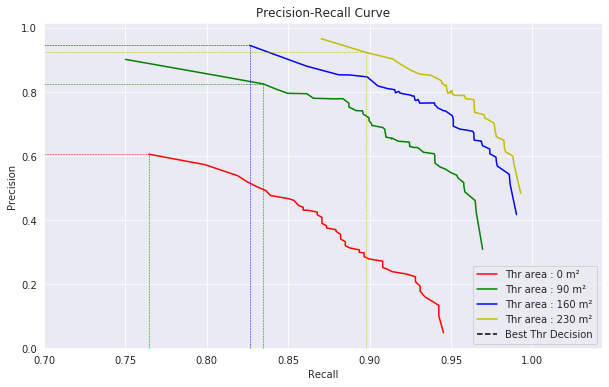

In [12]:
precisions = np.array(precisions)
recalls = np.array(recalls)
evf.plot_precision_recall_curve(precisions, recalls, multiline=True, labels=labels)